GMClustering is a pipeline of unsupervised methods that automatically separates measurements from MMS and THEMIS into different plasma regions, being the magnetosphere, the magnetosheath, and the solar wind. It's meant to simply provide predictions for data and offer visualizations and making it an overall simple and easy experience.

This Jupyter notebook covers how to use this package on a small sample dataset, the MMS-1 measurements processed for 2017. For our model training with MMS, we averaged measurements down to 1 minute resolution and only analyzed data between 7 <= R <= 35 RE, and this dataset reflects that.

# "What is the bare minimum I need to do to get this working?"

**Create dedicated environment (STRONGLY RECOMMENDED) and install the package:**

conda create --name gmclustering_env python=3.11

conda activate gmclustering_env

pip install git+https://github.com/jae1018/GMClustering.git

**Import the package, instantiate the model, call model.predict():**

In [1]:
# import
from gmclustering import GMClustering, utils
# instantiate
gmc = GMClustering()
# using example dataset that comes with the package
dat = utils.load_example_data()
# predict
preds = gmc.predict(dat)

# Getting Started

First, let's import the necessary packages

In [2]:
from gmclustering import GMClustering, utils
import numpy as np
# for additional visualizations
import matplotlib.pyplot as plt
import seaborn as sns

The sample MMS-1 dataset is included along with this package and can be loaded using the utils module. It contains the necessary variables to get a prediction, like magnetic field (BX, BY, BZ) and ion velocity (VX, VY, VZ) components, scalar ion temperature (T), and ion density (n), as well as the time (time) and position (X, Y, Z) of MMS1 at observation. Note that all vector data here is in GSE.

In [3]:
dat = utils.load_example_data()
print( list(dat) )

['BX', 'BY', 'BZ', 'T', 'VX', 'VY', 'VZ', 'X', 'Y', 'Z', 'n', 'time']


We can quickly visualze the positions of MMS1 in this dataset with a bivariate histogram

<Axes: xlabel='X', ylabel='Y'>

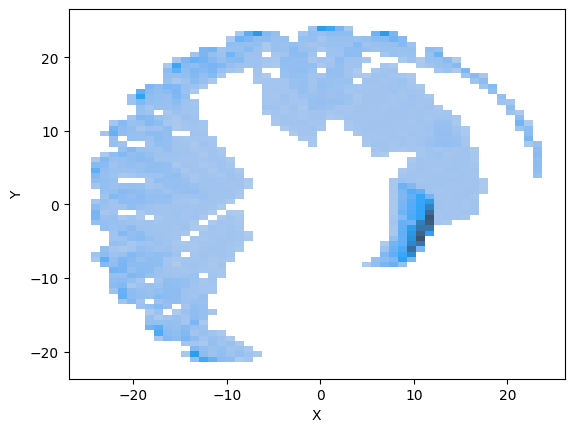

In [4]:
sns.histplot(dat, x='X', y='Y')

Now let's prepare the clustering model to analyze this data

In [5]:
gmc = GMClustering()

(If you see any warnings involving "CuPy could not be imported", it's not relevant for getting the model to work - just an issue that the XPySom package couldn't load CuPy; everything will still work without it)

The SOM nodes used to represent the original dataset are static and already have a "representative" position relative to the original training data. This means that you can analyze the clustering of the nodes as-they-are, without any data.

(<Figure size 800x400 with 3 Axes>, <Axes: >)

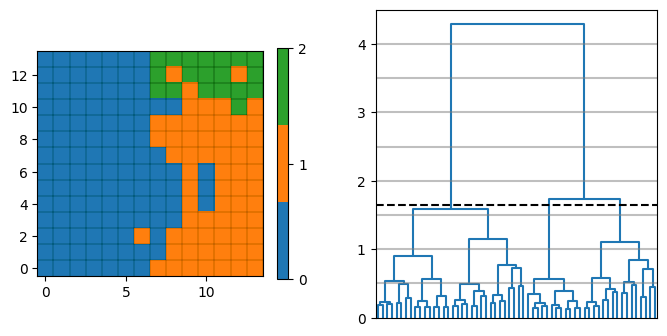

In [6]:
gmc.prepare_aggclust()
fig, axes = plt.subplots(1, 2, figsize=(8,4))
gmc.plot_som_clust(ax=axes[0])
dendrogram_kws = {'truncate_mode':'level', 'p':5}
gmc.plot_dendrogram(ax             = axes[1],
                    dendrogram_kws = dendrogram_kws)

As stated in the paper, the solar wind cluster is green (cluster 2), the magnetosheath cluster is orange (cluster 1), and the magnetosphere is blue (cluster 0). The dendrogram on the right shows how the clustering solution on the SOM nodes is made with a hierarchical agglomerative clustering model with a ward linkage. Using a threshold distance of 1.65 intersects three lines horizontally on the dendrogram, so this will yield three clusters.

# Making a Prediction

To make a prediction, you need the necessary variables. The format used for handling the data is pandas, so these relevant data should be handled using a pandas dataframe. As long as a dataframe object contains the columns BX, BY, BZ, VX, VY, VZ, n, T, a corresponding prediction can be made. The exact column names required can be seen from both a class constant of GMClustering as well as from the example dataset.

In [7]:
print( 'vars needed:',GMClustering.init_vars )
print( 'vars in the dataset:',list(dat) )

vars needed: ['BX', 'BY', 'BZ', 'VX', 'VY', 'VZ', 'n', 'T']
vars in the dataset: ['BX', 'BY', 'BZ', 'T', 'VX', 'VY', 'VZ', 'X', 'Y', 'Z', 'n', 'time']


Making a prediction (using the default clustering solution) is as simple as calling a predict function

In [8]:
preds = gmc.predict(dat)

# Visualizing Solutions

The utils module contains several functions for visualizing the solutions. There are a lot of points for a scatter plot, so it's better to use a bivariate histogram:

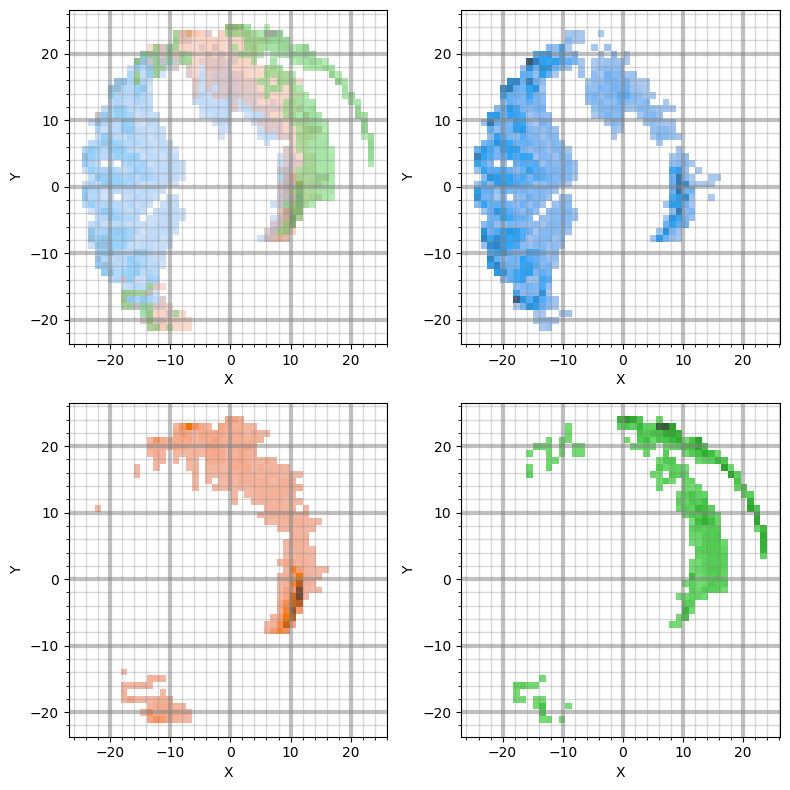

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>]],
       dtype=object))

In [9]:
# visualize predictions with a histogram over the clusters
utils.plot_xy_preds(dat, preds,
                    xy = ['X','Y'])

Additionally, 1d histograms can be used to depict the solutions.

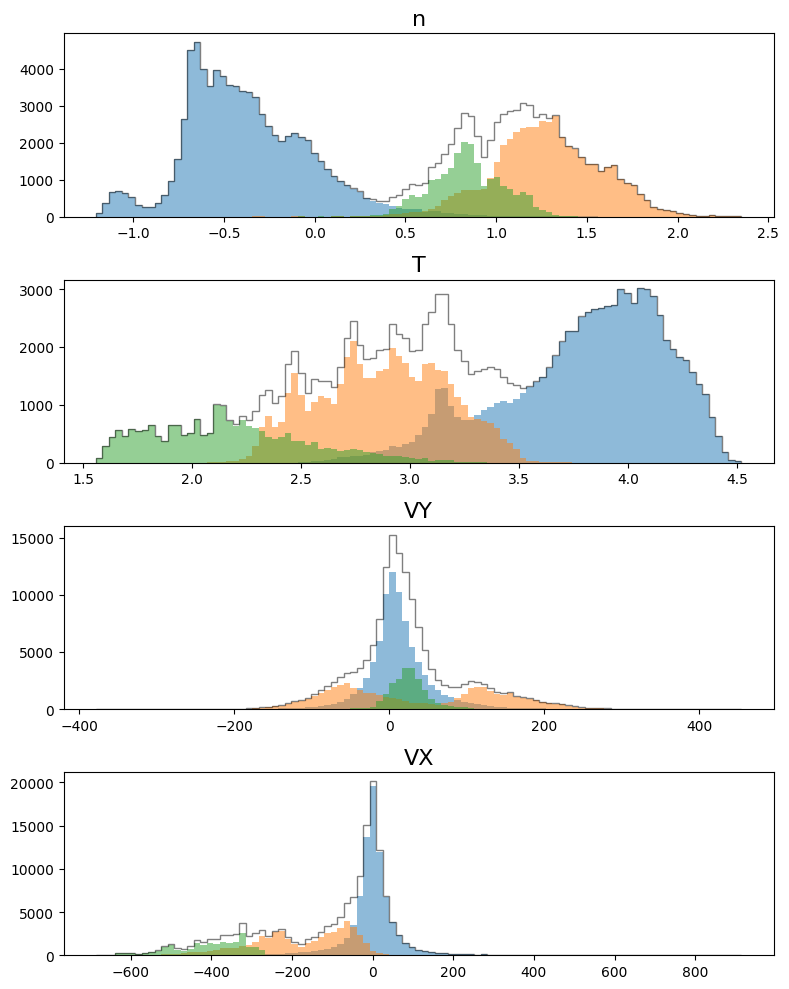

In [10]:
# visualize clusters as subsets of 1d histograms
fig, axes = utils.hist1d_vars(dat, preds,
                              hist_vars = ['n','T','VY','VX'],
                              logx      = ['n','T'],
                              fig_kws = {'figsize':(8,10)})
fig.tight_layout()

# Analyzing Sub-Clusters

The advantage of hierarchical analysis is that we can analyze sub-clusters of larger clusters. Getting clusters from the algorithm requires specifying a threshold distance and what cluster to unpack.

In [11]:
# Prepare tuple of distance to cutoff at and cluster to analyzer
magsphere_cluster = 0
original_distance = GMClustering.default_aggclust_dist
subset = (original_distance, magsphere_cluster)

gmc.prepare_aggclust(subset=subset)

Before we specify a distance for the sub-clustering, we can inspect the dendrogram to see what might be a good cutoff distance

(<Figure size 600x600 with 1 Axes>, <Axes: >)

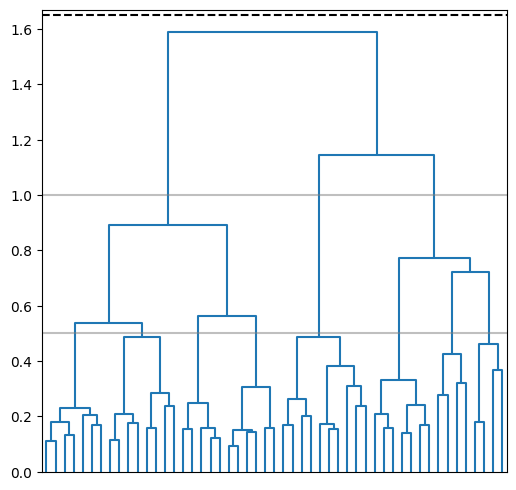

In [12]:
gmc.plot_dendrogram(dendrogram_kws = dendrogram_kws)

1.2 seems like a sensible value to get a couple of subclusters, so let's try that

In [13]:
gmc.prepare_aggclust(subset=subset, dist=1.2)

(<Figure size 800x400 with 3 Axes>, <Axes: >)

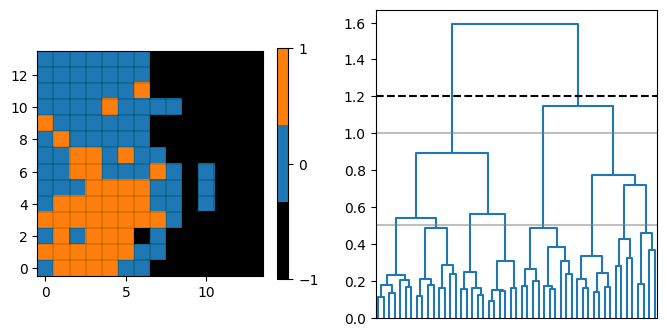

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
gmc.plot_som_clust(ax=axes[0])
gmc.plot_dendrogram(ax             = axes[1],
                    dendrogram_kws = dendrogram_kws)

The magnetosphere cluster was broken into 2 sub clusters. Nodes not belonging to the magnetosphere cluster are labeled with a -1 (in black). The other nodes are colored according to their grouping.

We can also get direct predictions for data relative to this clustering.

In [15]:
# gives predictions of 1, 0, and -1 according to the above image
subpreds = gmc.predict(dat)

# If you're only interested in the data that is part of the specified sub-cluster, you
# can easily filter out the -1 predictions with masking:
subdat = dat[subpreds != -1]
subpreds = subpreds[subpreds != -1]

# get counts of predictions
np.unique(subpreds, return_counts=True)

(array([0, 1], dtype=int32), array([75249,  6859]))

And just like earlier, we can analyze the distributions of the predictions

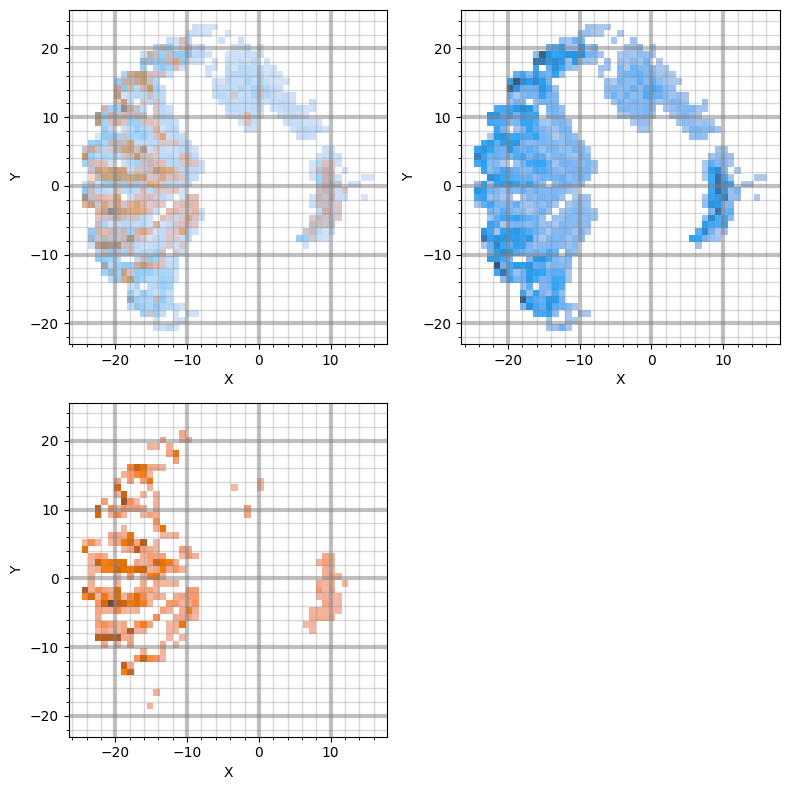

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

In [16]:
utils.plot_xy_preds(subdat, subpreds,
                    xy = ['X','Y'])

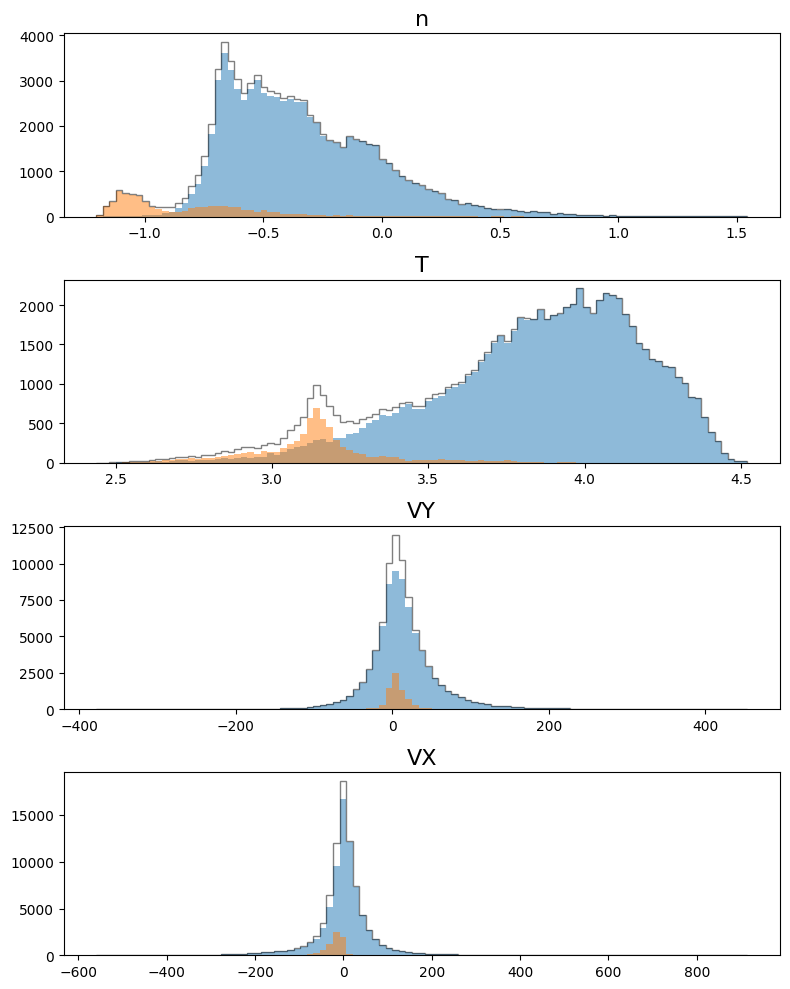

In [17]:
fig, axes = utils.hist1d_vars(subdat, subpreds,
                              hist_vars = ['n','T','VY','VX'],
                              logx      = ['n','T'],
                              fig_kws = {'figsize':(8,10)})
fig.tight_layout()